# Giving Memory Component To Langgraph

# Persistence

- In the langgraph workflow state will get erased after the workflow has completed.
- So the graph.invoke have no idea about previous state.
- Persistance in langgraph refers to the ability to save and restore the state of the workflow over time.
- It is not saving last state of graph but it save every intermediate state of graph.

## Checkpointers in Persistence

- Persistence in langgraph is implemented is using checkpointers.
- Checkpointers save state checkpoints after every superstep.
- Every superstep in graph will have a checkpoint saved by checkpointer.

## Threads in persistence

- Threads are unique ids against the checkpoints are saved.
- For every graph invoke you can give separate thread id for storing the result separately, or same id to store the results against one thread id.
- Think of it like a unique user_id

## Benefits of persistence

- Short Term Memory
- Fault Tolerance
- Human In The Loop
- Time Travel

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

In [2]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, ToolMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

model = init_chat_model(
    model="gemma3:4b",
    model_provider="ollama",
    temperature = 0.0
)

In [3]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages']

    # send to llm
    response = model.invoke(messages)

    # response store state
    return {'messages': [response]}

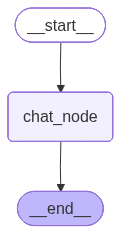

In [5]:
checkpointer =  MemorySaver()
graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer)

chatbot

In [8]:
thread_id =  '2'
config_1 = {"configurable": {"thread_id": thread_id}}

while True:
    query = input('User : ')
    print("User : ",query)
    
    print(query.strip())
    if query.strip().lower()  in ['exit','bye','quit']:
        break

    initial_state = {
        'messages': [HumanMessage(content=query)]
    }

    response = chatbot.invoke(initial_state, config=config_1)
    print("Ai : ",response['messages'][-1].content)

User :  hi
hi
Ai :  Hey! 😊 How’s it going? 

Anything you’re thinking about today, or just passing the time?
User :  what is 2+2
what is 2+2
Ai :  2 + 2 = 4! 

Simple math! 😄 

Is there anything else you’d like to calculate, or maybe learn about?
User :  bye
bye


### Collections of final states

In [10]:
for chat in chatbot.get_state(config_1).values['messages']:
    print(chat)

content='hi' additional_kwargs={} response_metadata={} id='5571d984-a580-4981-9dd1-cfc940d36993'
content="Hi there! How's your day going so far? Is there anything you'd like to chat about, or were you just saying hello? 😊 \n\nI'm here to help with just about anything – answering questions, brainstorming ideas, writing stories, or just having a conversation." additional_kwargs={} response_metadata={'model': 'gemma3:4b', 'created_at': '2026-02-22T15:58:22.3019678Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9725402300, 'load_duration': 7019764900, 'prompt_eval_count': 10, 'prompt_eval_duration': 146336200, 'eval_count': 60, 'eval_duration': 2443791300, 'logprobs': None, 'model_name': 'gemma3:4b', 'model_provider': 'ollama'} id='lc_run--019c8612-9c53-7790-9ef6-424711e2fb1a-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 10, 'output_tokens': 60, 'total_tokens': 70}
content='hi' additional_kwargs={} response_metadata={} id='3a796b15-d275-4d7c-acc3-0a0e27f

### Intermediate states of graph

In [13]:
list(chatbot.get_state_history(config_1))

[StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5571d984-a580-4981-9dd1-cfc940d36993'), AIMessage(content="Hi there! How's your day going so far? Is there anything you'd like to chat about, or were you just saying hello? 😊 \n\nI'm here to help with just about anything – answering questions, brainstorming ideas, writing stories, or just having a conversation.", additional_kwargs={}, response_metadata={'model': 'gemma3:4b', 'created_at': '2026-02-22T15:58:22.3019678Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9725402300, 'load_duration': 7019764900, 'prompt_eval_count': 10, 'prompt_eval_duration': 146336200, 'eval_count': 60, 'eval_duration': 2443791300, 'logprobs': None, 'model_name': 'gemma3:4b', 'model_provider': 'ollama'}, id='lc_run--019c8612-9c53-7790-9ef6-424711e2fb1a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 10, 'output_tokens': 60, 'total_tokens': 70}), HumanMessage(conte